In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import sys
import os

from pathlib import Path
p = Path(os.getcwd()).parents[1]
sys.path.append(p.__str__())

from src import train, generate, eval
#from runfiles import train, generate, eval
from modules.config import read_config
import modules.plots as plots
from modules.datageneration import load_data, data_functions
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib
matplotlib.rcParams['axes.unicode_minus']=False
import seaborn as sns
import os
import pyro
import pyro.poutine as poutine
import json
import math

sns.set_style("whitegrid", {'axes.edgecolor' : '.1', 'axes.linewidth': 0.3, 'xtick.bottom': True,
    'ytick.left': True,
})

/Users/alvar/miniconda3/envs/master/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
BASE_DIR = "../../tests/sanity_check/"

# make plots dir
if not os.path.exists(BASE_DIR + "plots"):
    os.makedirs(BASE_DIR + "plots")

# make tables dir
if not os.path.exists(BASE_DIR + "tables"):
    os.makedirs(BASE_DIR + "tables")

In [4]:
configs = read_config(f"{BASE_DIR}/config.ini")
dataset_configs = read_config(f"{BASE_DIR}/dataset_config.ini")

profiles= ["tyxe-test"] #"multisin10-1x16-s05", "multisin10-1x16-sl", "multisin10-linear-s05", "multisin10-linear-sl"]

names = [configs[p]["NAME"] for p in profiles]

prop_cycle = plt.rcParams['axes.prop_cycle']
plt_colors = prop_cycle.by_key()['color']

colors = [plt_colors[i] for i in range(len(profiles))]

reruns = 1

In [5]:
configs.keys()

KeysView(<configparser.ConfigParser object at 0x10784e7f0>)

In [6]:


train_stats = {}
for p in profiles:
    name = configs[p]["NAME"]
    train_stats[name] = []
    for run in range(1, reruns+1):
        with open(f"{BASE_DIR}/results/{name}/train_stats_{run}.json", "r") as f:
            train_stats[name].append(json.load(f))

results = {}
for p in profiles:
    name = configs[p]["NAME"]
    results[name] = []
    for run in range(1, reruns+1):
        with open(f"{BASE_DIR}/results/{name}/results_{run}.json", "r") as f:
            results[name].append(json.load(f))

# Load posterior samples
posterior_samples = {}
for p in profiles:
    name = configs[p]["NAME"]
    posterior_samples[name] = []
    # Load posterior samples
    for run in range(1, reruns+1):
        train = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/train_samples_{run}.npy")
        test = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/test_samples_{run}.npy")
        test_in_domain = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/test_in_domain_samples_{run}.npy")
        test_out_domain = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/test_out_domain_samples_{run}.npy")

        posterior_samples[name].append({
            "train": train,
            "test": test,
            "test_in_domain": test_in_domain,
            "test_out_domain": test_out_domain
        })

In [7]:
[results[profiles[0]][i]["in_domain"]["error"]["rmse"] for i in range(reruns)]

[0.7186155915260315]

In [8]:
#Generate table for Train
temp_t = pd.DataFrame(columns=["name", "lik-std-mean", "lik-std-std", "rmse-mean", "rmse-std", "mae-mean", "mae-std", "ll-mean", "ll-std"])

for p in profiles:
    name = configs[p]["NAME"]
    rmse_mean = np.mean([results[name][i]["train"]["error"]["rmse"] for i in range(reruns)])
    rmse_std = np.std([results[name][i]["train"]["error"]["rmse"] for i in range(reruns)])
    mae_mean = np.mean([results[name][i]["train"]["error"]["mae"] for i in range(reruns)])
    mae_std = np.std([results[name][i]["train"]["error"]["mae"] for i in range(reruns)])
    ll_mean = np.mean([results[name][i]["train"]["error"]["loglikelihood"] for i in range(reruns)])
    ll_std = np.std([results[name][i]["train"]["error"]["loglikelihood"] for i in range(reruns)])
    lik_std_mean = [train_stats[name][i]["likelihood"]["mean"] for i in range(reruns)]
    lik_std_std = [train_stats[name][i]["likelihood"]["std"] for i in range(reruns)]
    temp_t = temp_t._append({
        "name": name,
        "lik-std-mean": np.mean(lik_std_mean),
        "lik-std-std": np.sqrt(np.var(lik_std_mean) + np.mean(lik_std_std)**2),
        "rmse-mean": rmse_mean,
        "rmse-std": rmse_std,
        "mae-mean": mae_mean,
        "mae-std": mae_std,
        "ll-mean": ll_mean,
        "ll-std": ll_std
    }, ignore_index=True)

table = pd.DataFrame(columns=["Name", "Likelihood_std", "RMSE", "MAE", "LL"])

round = 2
for p in profiles:
    name = configs[p]["NAME"]
    table["Name"] = temp_t["name"]
    table["Likelihood_std"] = temp_t["lik-std-mean"].round(round).astype(str).add('±').add(temp_t["lik-std-std"].multiply(2).round(round).astype(str))
    table["RMSE"] = temp_t["rmse-mean"].round(round).astype(str).add('±').add(temp_t["rmse-std"].multiply(2).round(round).astype(str))
    table["MAE"] = temp_t["mae-mean"].round(round).astype(str).add('±').add(temp_t["mae-std"].multiply(2).round(round).astype(str))
    table["LL"] = temp_t["ll-mean"].round(round).astype(str).add('±').add(temp_t["ll-std"].multiply(2).round(round).astype(str))

table = table.set_index("Name")
table.to_csv(f"{BASE_DIR}/tables/train.csv")

print("TRAIN")
display(table)
print()

# Generate table for in_domain
temp_t = pd.DataFrame(columns=["name", "lik-std-mean", "lik-std-std", "rmse-mean", "rmse-std", "mae-mean", "mae-std", "ll-mean", "ll-std"])

for p in profiles:
    name = configs[p]["NAME"]
    rmse_mean = np.mean([results[name][i]["in_domain"]["error"]["rmse"] for i in range(reruns)])
    rmse_std = np.std([results[name][i]["in_domain"]["error"]["rmse"] for i in range(reruns)])
    mae_mean = np.mean([results[name][i]["in_domain"]["error"]["mae"] for i in range(reruns)])
    mae_std = np.std([results[name][i]["in_domain"]["error"]["mae"] for i in range(reruns)])
    ll_mean = np.mean([results[name][i]["in_domain"]["error"]["loglikelihood"] for i in range(reruns)])
    ll_std = np.std([results[name][i]["in_domain"]["error"]["loglikelihood"] for i in range(reruns)])
    lik_std_mean = [train_stats[name][i]["likelihood"]["mean"] for i in range(reruns)]
    lik_std_std = [train_stats[name][i]["likelihood"]["std"] for i in range(reruns)]
    temp_t = temp_t._append({
        "name": name,
        "lik-std-mean": np.mean(lik_std_mean),
        "lik-std-std": np.sqrt(np.var(lik_std_mean) + np.mean(lik_std_std)**2),
        "rmse-mean": rmse_mean,
        "rmse-std": rmse_std,
        "mae-mean": mae_mean,
        "mae-std": mae_std,
        "ll-mean": ll_mean,
        "ll-std": ll_std
    }, ignore_index=True)

table = pd.DataFrame(columns=["Name", "Likelihood_std", "RMSE", "MAE", "LL"])

round = 2
for p in profiles:
    name = configs[p]["NAME"]
    table["Name"] = temp_t["name"]
    table["Likelihood_std"] = temp_t["lik-std-mean"].round(round).astype(str).add('±').add(temp_t["lik-std-std"].multiply(2).round(round).astype(str))
    table["RMSE"] = temp_t["rmse-mean"].round(round).astype(str).add('±').add(temp_t["rmse-std"].multiply(2).round(round).astype(str))
    table["MAE"] = temp_t["mae-mean"].round(round).astype(str).add('±').add(temp_t["mae-std"].multiply(2).round(round).astype(str))
    table["LL"] = temp_t["ll-mean"].round(round).astype(str).add('±').add(temp_t["ll-std"].multiply(2).round(round).astype(str))

table = table.set_index("Name")
table.to_csv(f"{BASE_DIR}/tables/in_domain.csv")

print("IN DOMAIN")
display(table)
print()


# Generate table for out_domain
temp_t = pd.DataFrame(columns=["name", "lik-std-mean", "lik-std-std", "rmse-mean", "rmse-std", "mae-mean", "mae-std", "ll-mean", "ll-std"])

for p in profiles:
    name = configs[p]["NAME"]
    rmse_mean = np.mean([results[name][i]["out_domain"]["error"]["rmse"] for i in range(reruns)])
    rmse_std = np.std([results[name][i]["out_domain"]["error"]["rmse"] for i in range(reruns)])
    mae_mean = np.mean([results[name][i]["out_domain"]["error"]["mae"] for i in range(reruns)])
    mae_std = np.std([results[name][i]["out_domain"]["error"]["mae"] for i in range(reruns)])
    ll_mean = np.mean([results[name][i]["out_domain"]["error"]["loglikelihood"] for i in range(reruns)])
    ll_std = np.std([results[name][i]["out_domain"]["error"]["loglikelihood"] for i in range(reruns)])
    lik_std_mean = [train_stats[name][i]["likelihood"]["mean"] for i in range(reruns)]
    lik_std_std = [train_stats[name][i]["likelihood"]["std"] for i in range(reruns)]
    temp_t = temp_t._append({
        "name": name,
        "lik-std-mean": np.mean(lik_std_mean),
        "lik-std-std": np.sqrt(np.var(lik_std_mean) + np.mean(lik_std_std)**2),
        "rmse-mean": rmse_mean,
        "rmse-std": rmse_std,
        "mae-mean": mae_mean,
        "mae-std": mae_std,
        "ll-mean": ll_mean,
        "ll-std": ll_std
    }, ignore_index=True)

table = pd.DataFrame(columns=["Name", "Likelihood_std", "RMSE", "MAE", "LL"])

round = 2
for p in profiles:
    name = configs[p]["NAME"]
    table["Name"] = temp_t["name"]
    table["Likelihood_std"] = temp_t["lik-std-mean"].round(round).astype(str).add('±').add(temp_t["lik-std-std"].multiply(2).round(round).astype(str))
    table["RMSE"] = temp_t["rmse-mean"].round(round).astype(str).add('±').add(temp_t["rmse-std"].multiply(2).round(round).astype(str))
    table["MAE"] = temp_t["mae-mean"].round(round).astype(str).add('±').add(temp_t["mae-std"].multiply(2).round(round).astype(str))
    table["LL"] = temp_t["ll-mean"].round(round).astype(str).add('±').add(temp_t["ll-std"].multiply(2).round(round).astype(str))

table = table.set_index("Name")
table.to_csv(f"{BASE_DIR}/tables/out_domain.csv")

print("OUT DOMAIN")
display(table)
print()


TRAIN


,Likelihood_std,RMSE,MAE,LL
Name,,,,
tyxe-test,0.3±0.0,0.71±0.0,0.6±0.0,-2.21±0.0



IN DOMAIN


,Likelihood_std,RMSE,MAE,LL
Name,,,,
tyxe-test,0.3±0.0,0.72±0.0,0.61±0.0,-2.28±0.0



OUT DOMAIN


,Likelihood_std,RMSE,MAE,LL
Name,,,,
tyxe-test,0.3±0.0,1.34±0.0,1.15±0.0,-3.61±0.0


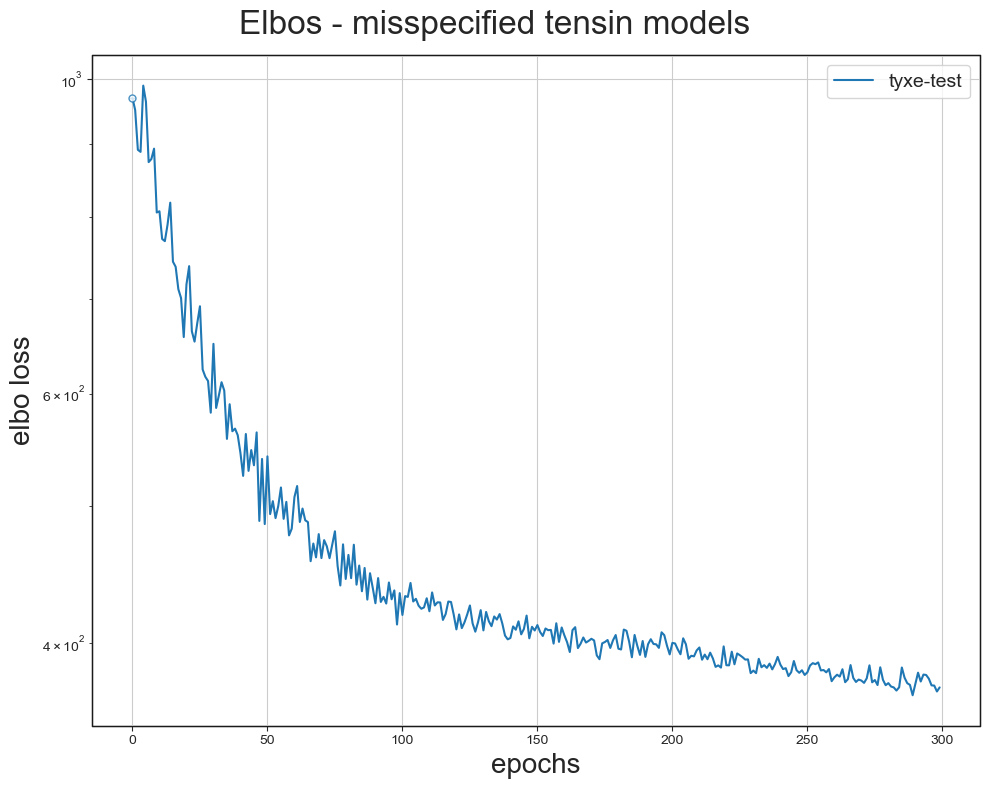

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))
fig.suptitle("Elbos - misspecified tensin models", fontsize=24)
for i, p in enumerate(profiles):
    name = configs[p]["NAME"]
    elbos = [train_stats[name][i]["elbos"] for i in range(reruns)]
    means = np.mean(elbos, axis=0)
    stds = np.std(elbos, axis=0)
    ax.plot(means, label=name, color=colors[i])

    err_range = list(range(0, len(means), 1000))
    #ax.fill_between(range(len(means)), means-stds, means+(stds * 2), alpha=0.2, color=colors[i])
    plt.errorbar(err_range, means[err_range], yerr=stds[err_range], fmt='o', color=colors[i], ms=5, mfc='white', alpha=0.8, fillstyle="full", capsize=2)
ax.set_yscale("log", base=10)
ax.patch.set_linewidth(1) 
ax.patch.set_edgecolor('black')
ax.legend( fontsize=14, ncol=2, loc="upper right")
ax.set_xlabel("epochs", fontsize=20)
ax.set_ylabel("elbo loss", fontsize=20)
plt.tight_layout()
plt.savefig(f"{BASE_DIR}/plots/elbos.svg", format="svg")
plt.show()

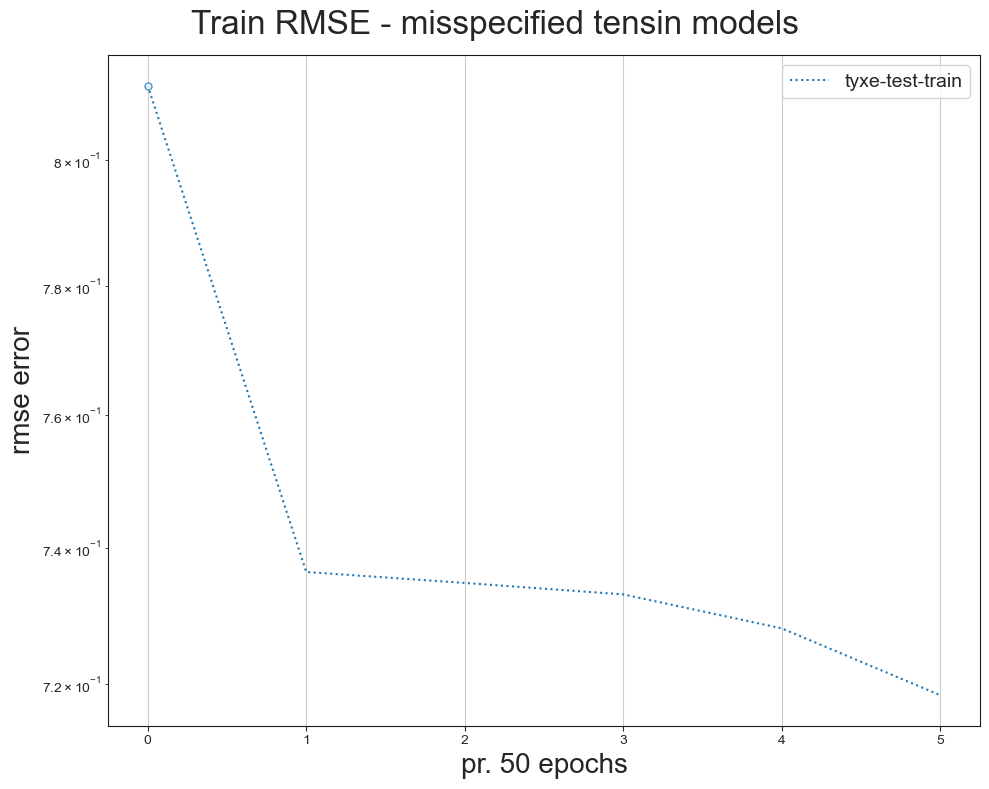

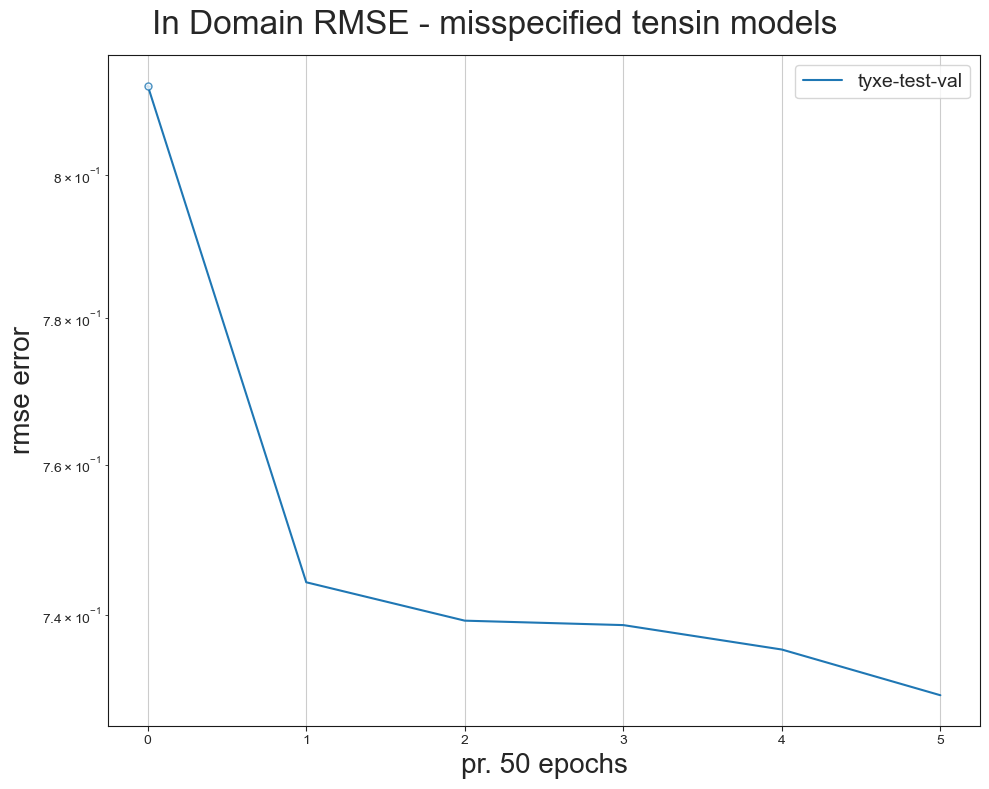

In [10]:
#plot rmse
fig, ax = plt.subplots(figsize=(10, 8))
fig.suptitle("Train RMSE - misspecified tensin models", fontsize=24)
for i, p in enumerate(profiles):
    name = configs[p]["NAME"]
    te = [train_stats[name][i]["train_rmse"] for i in range(reruns)]
    means = np.mean(te, axis=0)
    stds = np.std(te, axis=0)
    ax.plot(means, ':', label=f"{name}-train", color=colors[i])
    #ax.fill_between(range(len(means)), means-stds, means+(stds * 2), alpha=0.1, color=colors[i])
    err_range = list(range(0, len(means), 10))
    #ax.fill_between(range(len(means)), means-stds, means+(stds * 2), alpha=0.2, color=colors[i])
    plt.errorbar(err_range, means[err_range], yerr=stds[err_range], fmt='o', color=colors[i], ms=5, mfc='white', alpha=0.8, fillstyle="full", capsize=2)
    ax.set_yscale('log')
ax.legend( ncol=2, fontsize=14)
ax.set_xlabel("pr. 50 epochs", fontsize=20)
ax.set_ylabel("rmse error", fontsize=20)
#tight layout
plt.tight_layout()
plt.savefig(f"{BASE_DIR}/plots/rmse_train.svg", format="svg")
plt.show()

#plot rmse
fig, ax = plt.subplots(figsize=(10, 8))
fig.suptitle("In Domain RMSE - misspecified tensin models", fontsize=24)
for i, p in enumerate(profiles):
    name = configs[p]["NAME"]
    ve = [train_stats[name][i]["val_rmse"] for i in range(reruns)]
    means = np.mean(ve, axis=0)
    stds = np.std(ve, axis=0)
    ax.plot(means, label=f"{name}-val", color=colors[i])
    #ax.fill_between(range(len(means)), means-stds, means+(stds * 2), alpha=0.2, color=colors[i], hatch='//')
    err_range = list(range(0, len(means), 10))
    #ax.fill_between(range(len(means)), means-stds, means+(stds * 2), alpha=0.2, color=colors[i])
    plt.errorbar(err_range, means[err_range], yerr=stds[err_range], fmt='o', color=colors[i], ms=5, mfc='white', alpha=0.8, fillstyle="full", capsize=2)
    ax.set_yscale('log')
ax.legend(ncol=2, fontsize=14)
ax.set_xlabel("pr. 50 epochs", fontsize=20)
ax.set_ylabel("rmse error", fontsize=20)
#tight layout
plt.tight_layout()
plt.savefig(f"{BASE_DIR}/plots/rmse_in_domain.svg", format="svg")
plt.show()

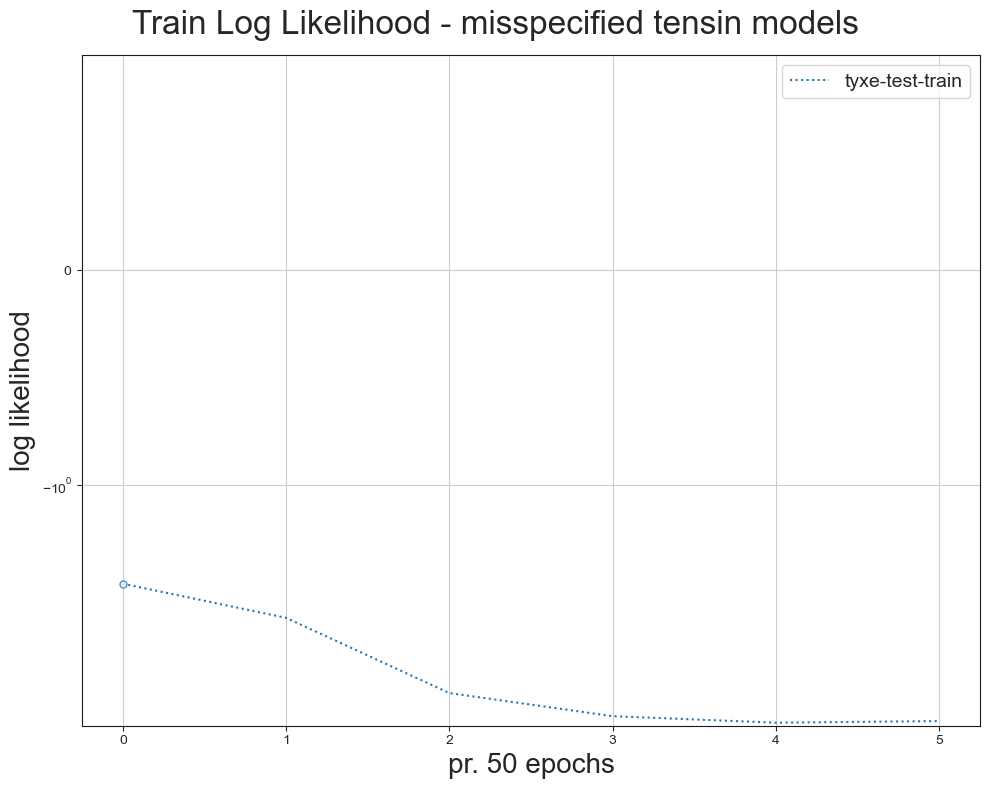

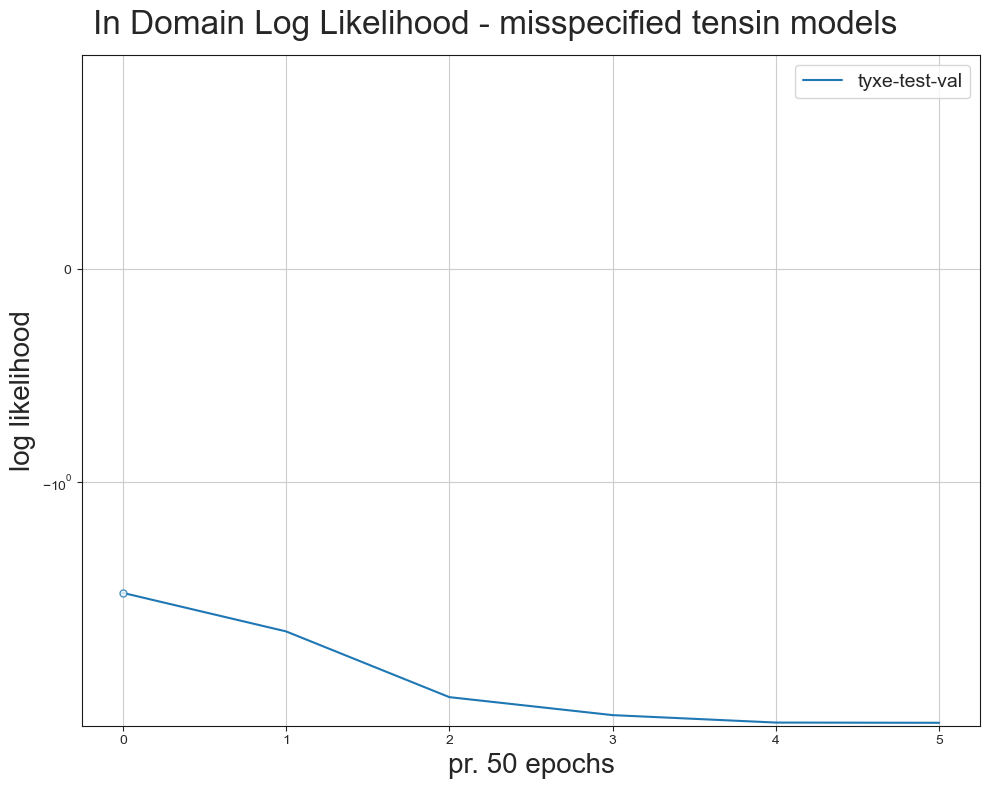

In [11]:
#plot log likelihood
fig, ax = plt.subplots(figsize=(10, 8))
fig.suptitle("Train Log Likelihood - misspecified tensin models", fontsize=24)
for i, p in enumerate(profiles):
    name = configs[p]["NAME"]
    te = [train_stats[name][i]["train_ll"] for i in range(reruns)]
    means = np.mean(te, axis=0)
    stds = np.std(te, axis=0)
    ax.plot(means, ':', label=f"{name}-train", color=colors[i])
    err_range = list(range(0, len(means), 10))
    #ax.fill_between(range(len(means)), means-stds, means+(stds * 2), alpha=0.2, color=colors[i])
    plt.errorbar(err_range, means[err_range], yerr=stds[err_range], fmt='o', color=colors[i], ms=5, mfc='white', alpha=0.8, fillstyle="full", capsize=2)
plt.ylim(top=1)
ax.legend(ncol=2, fontsize=14)
ax.set_yscale("symlog")
ax.set_xlabel("pr. 50 epochs", fontsize=20)
ax.set_ylabel("log likelihood", fontsize=20)
#tight layout
plt.tight_layout()
plt.savefig(f"{BASE_DIR}/plots/ll-train.svg", format="svg")
plt.show()

#plot log likelihood
fig, ax = plt.subplots(figsize=(10, 8))
fig.suptitle("In Domain Log Likelihood - misspecified tensin models", fontsize=24)
for i, p in enumerate(profiles):
    name = configs[p]["NAME"]
    ve = [train_stats[name][i]["val_ll"] for i in range(reruns)]
    means = np.mean(ve, axis=0)
    stds = np.std(ve, axis=0)
    ax.plot(means, label=f"{name}-val", color=colors[i])
    err_range = list(range(0, len(means), 20))
    #ax.fill_between(range(len(means)), means-stds, means+(stds * 2), alpha=0.2, color=colors[i])
    plt.errorbar(err_range, means[err_range], yerr=stds[err_range], fmt='o', color=colors[i], ms=5, mfc='white', alpha=0.8, fillstyle="full", capsize=2)
plt.ylim(top=1)
ax.legend(ncol=2, fontsize=14)
ax.set_yscale("symlog")
ax.set_xlabel("pr. 50 epochs", fontsize=20)
ax.set_ylabel("log likelihood", fontsize=20)
#tight layout
plt.tight_layout()
plt.savefig(f"{BASE_DIR}/plots/ll-in-domain.svg", format="svg")
plt.show()

In [12]:
run = 1

name1 = configs[profiles[0]]["NAME"]
data_samples = {
    "train_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/train_x.npy"),
    "test_in_domain_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_in_domain_x.npy"),
    "test_out_domain_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_out_domain_x.npy"),
    #"test_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_x.npy"),
    "train_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/train_dist_samples.npy"),
    "test_in_domain_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_in_domain_dist_samples.npy"),
    "test_out_domain_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_out_domain_dist_samples.npy"),
    #"test_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_dist_samples.npy"),
}


In [13]:
print(data_samples["train_x"].shape)
print(data_samples["train_dist_samples"].shape)
print(posterior_samples[name1][0]["train"].shape)

(1000, 1)
(1000, 1000)
(1000, 1000)


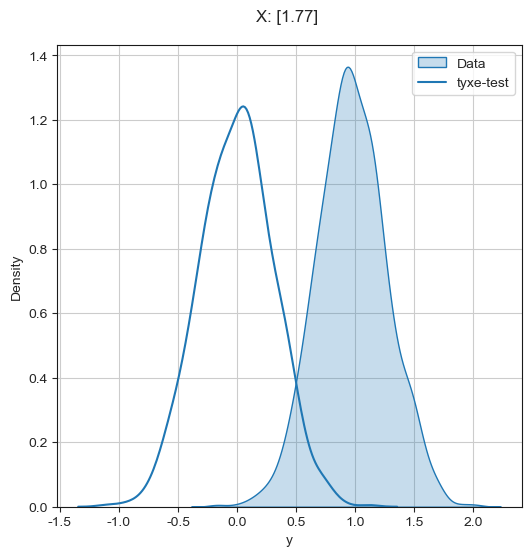

In [14]:
# Plot posterior samples
labels = [configs[p]["NAME"] for p in profiles]
x_samp = data_samples["train_x"][1]
train_samp = data_samples["train_dist_samples"][:, 1]
pred_train_samples = [posterior_samples[p][run-1]["train"][:, 1] for p in profiles]
plots.plot_comparisons(pred_train_samples, train_samp, labels=labels, figsize=(6,6), x_sample=x_samp, title="Posterior samples - Train", save_path=f"{BASE_DIR}/results/posterior_comparison.png")

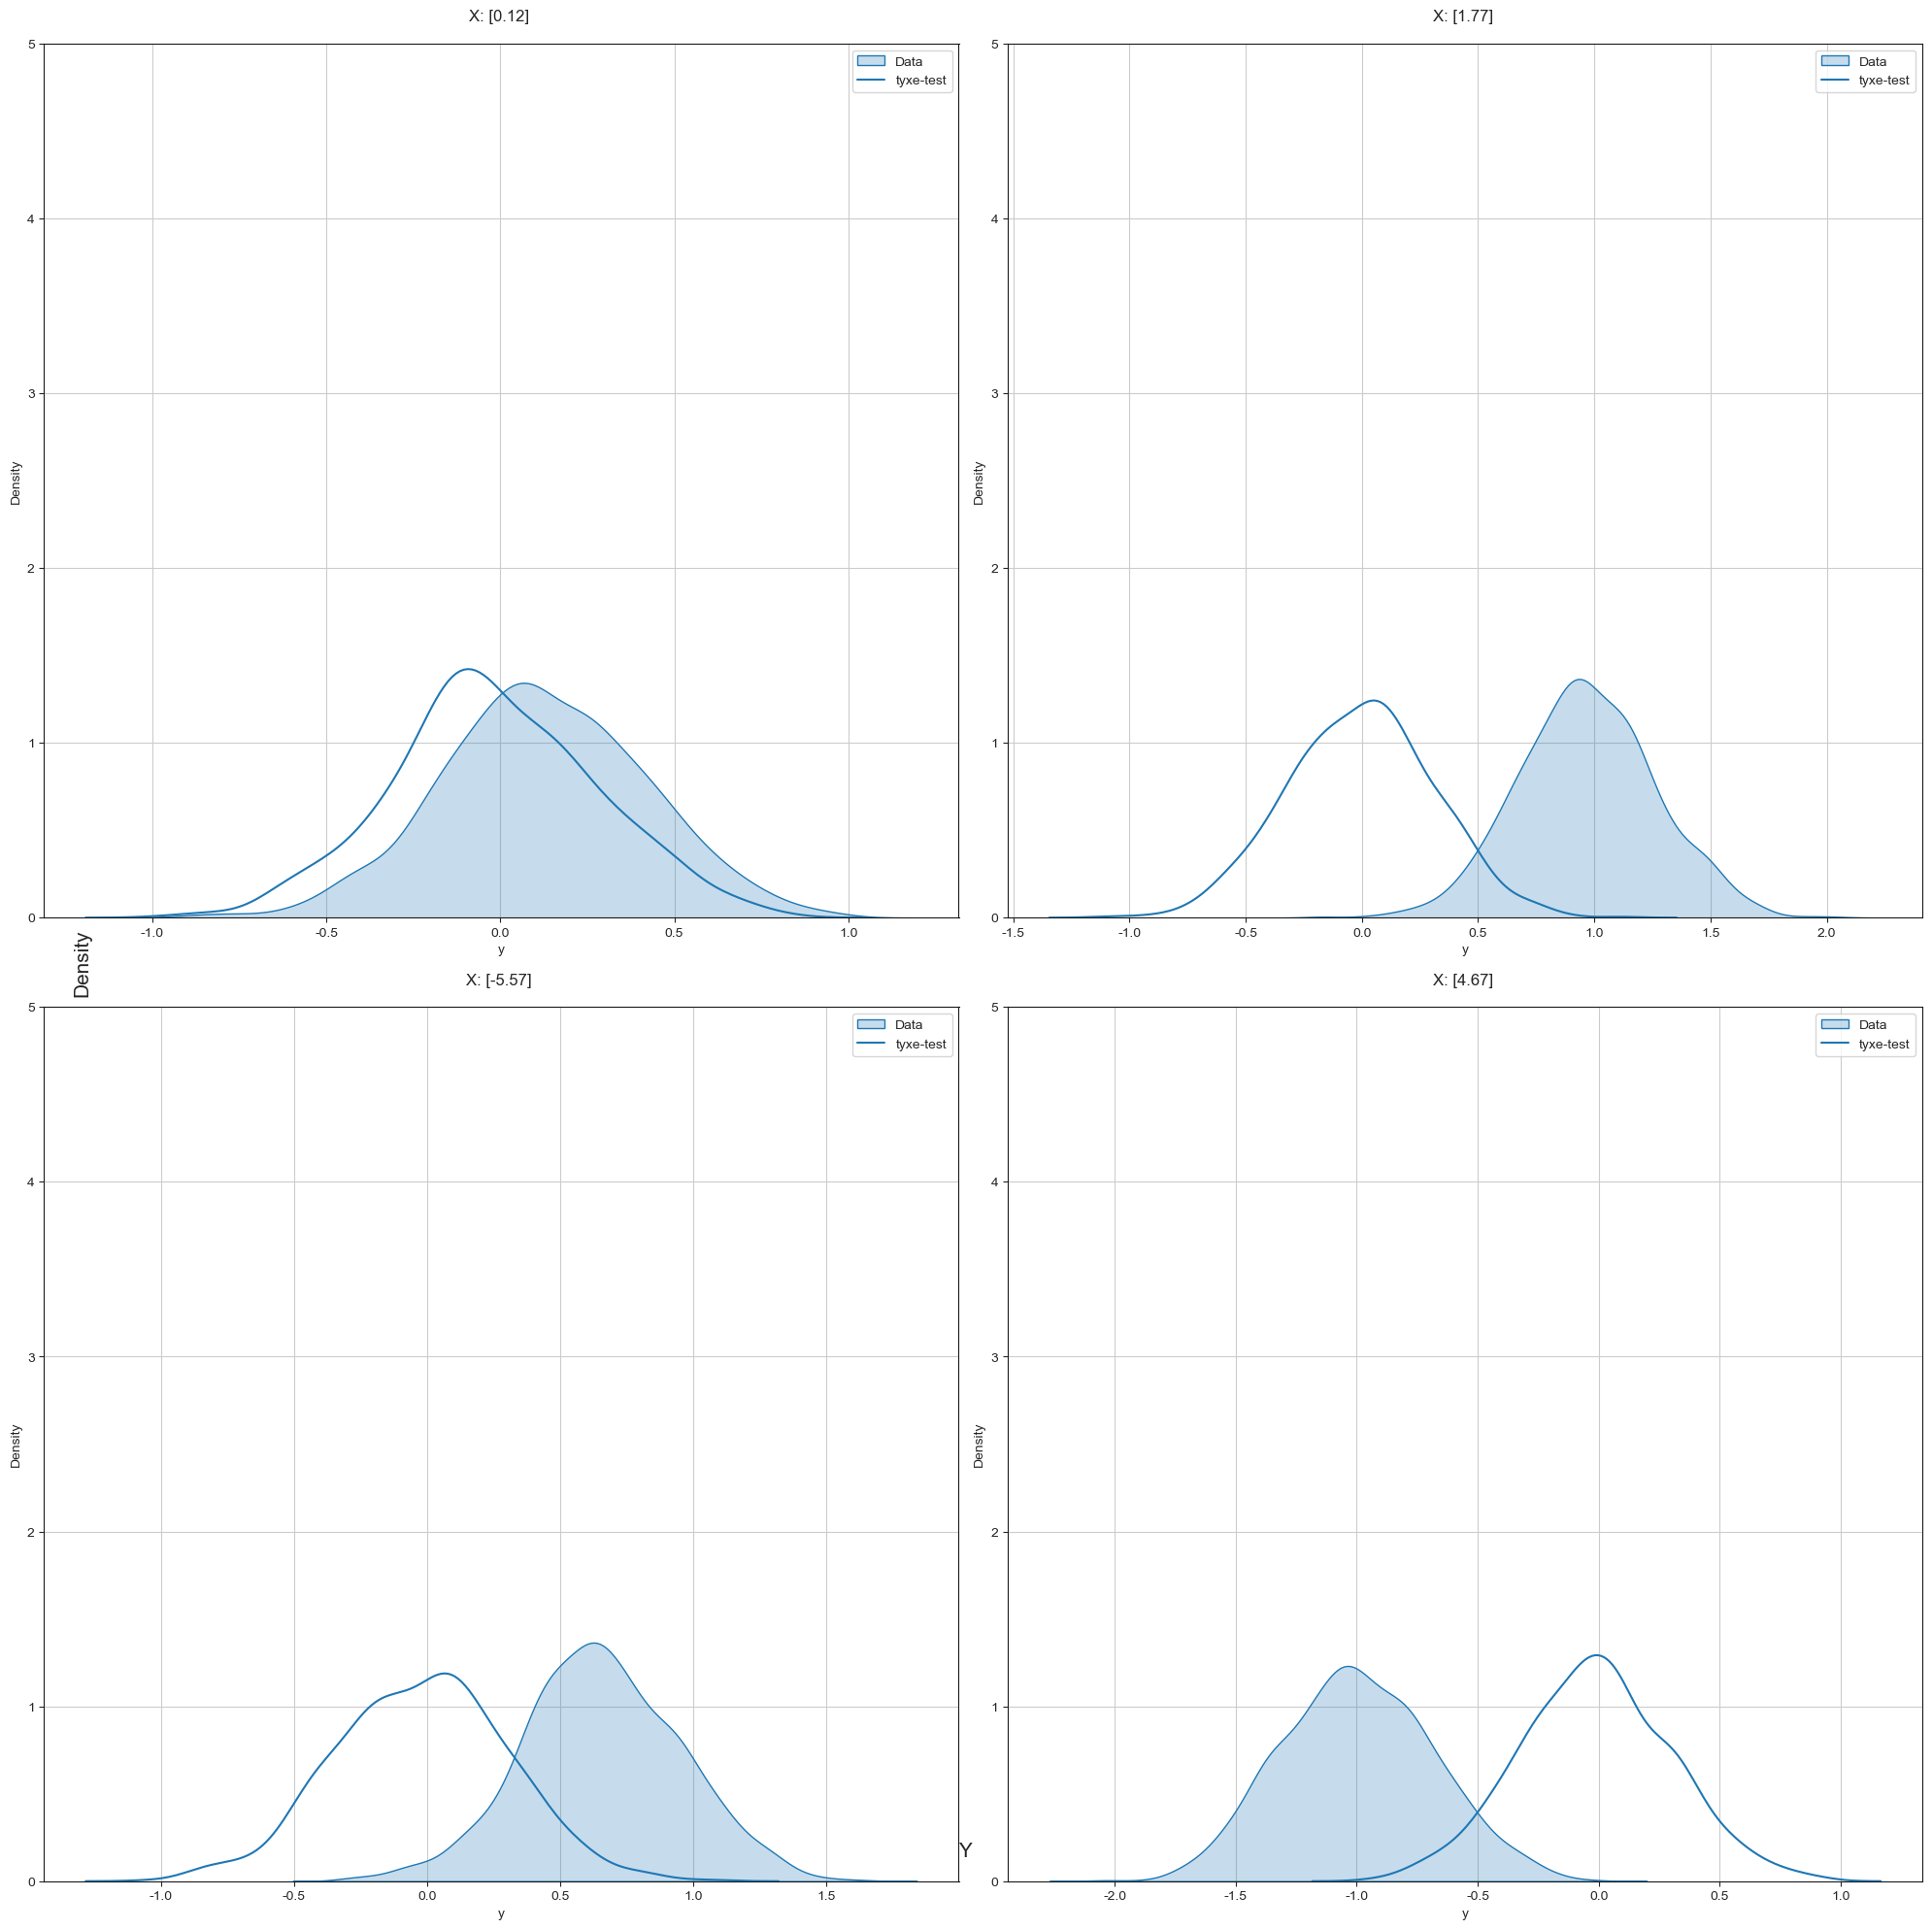

In [15]:

fig, axs = plt.subplots(2, 2, figsize=(20, 20))
axs = axs.flatten()
fig.tight_layout()
#fig.suptitle(title, fontsize=15)
fig.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.4, wspace=0.4)
fig.text(0.5, 0.04, 'Y', ha='center', fontsize=15)
fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=15)

for i, ax in enumerate(axs):
    labels = [configs[p]["NAME"] for p in profiles]
    x_samp = data_samples["train_x"][i]
    train_samp = data_samples["train_dist_samples"][:, i]
    pred_train_samples = [posterior_samples[p][run-1]["train"][:, i] for p in profiles]
    plots.plot_comparisons(pred_train_samples, train_samp, labels=labels, x_sample=x_samp, ax=ax)   
    ax.set_ylim([0, 5])

plt.tight_layout()

plt.show()

In [16]:
weight_samples = {}
for p in profiles:
    name = configs[p]["NAME"]
    weight_samples[name] = []
    for run in range(1, reruns+1):
        with open(f"{BASE_DIR}/results/{name}/weight_dist_{run}.json", "r") as f:
            weight_samples[name].append(json.load(f))

In [17]:
weight_scales = {}
for p in profiles:
    name = configs[p]["NAME"]
    weight_scales[name] = []
    for run in range(1, reruns+1):
        w_samp = weight_samples[name][run-1]
        print(w_samp.keys())
        for n, w in w_samp.items():
            if "scale" in n:
                weight_scales[name].extend(w)

dict_keys(['net_guide.net.0.weight.loc', 'net_guide.net.0.weight.scale', 'net_guide.net.0.bias.loc', 'net_guide.net.0.bias.scale', 'net_guide.net.2.weight.loc', 'net_guide.net.2.weight.scale', 'net_guide.net.2.bias.loc', 'net_guide.net.2.bias.scale'])


In [18]:
weight_scales["tyxe-test"]

[0.056789252907037735,
 0.061708543449640274,
 0.04403918609023094,
 0.07334829866886139,
 0.04864828288555145,
 0.06540168821811676,
 0.06787672638893127,
 0.07597599923610687,
 0.02236959896981716,
 0.07745114713907242,
 0.06935502588748932,
 0.07295692712068558,
 0.06769873946905136,
 0.05885717272758484,
 0.06076069176197052,
 0.0778241902589798,
 0.05873378366231918,
 0.07089296728372574,
 0.052544932812452316,
 0.058077700436115265,
 0.07293669879436493,
 0.06952141225337982,
 0.0651496946811676,
 0.07168719172477722,
 0.07305742800235748,
 0.0353349968791008,
 0.0632026344537735,
 0.06768948584794998,
 0.07455502450466156,
 0.07944892346858978,
 0.06582570821046829,
 0.0707705020904541,
 0.22049768269062042,
 0.1301480084657669,
 0.051518864929676056,
 0.2854422926902771,
 0.0646473690867424,
 0.2979629337787628,
 0.2956007719039917,
 0.25910669565200806,
 0.06321240216493607,
 0.2230481505393982,
 0.22954201698303223,
 0.2508207857608795,
 0.22915221750736237,
 0.11039633303880

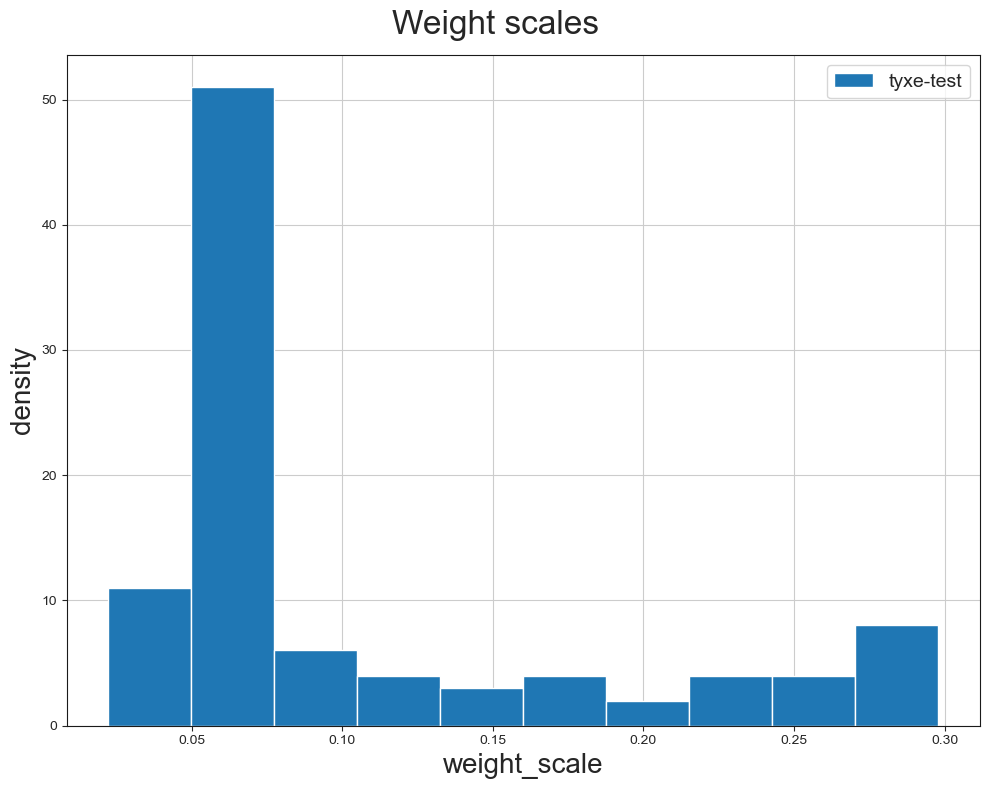

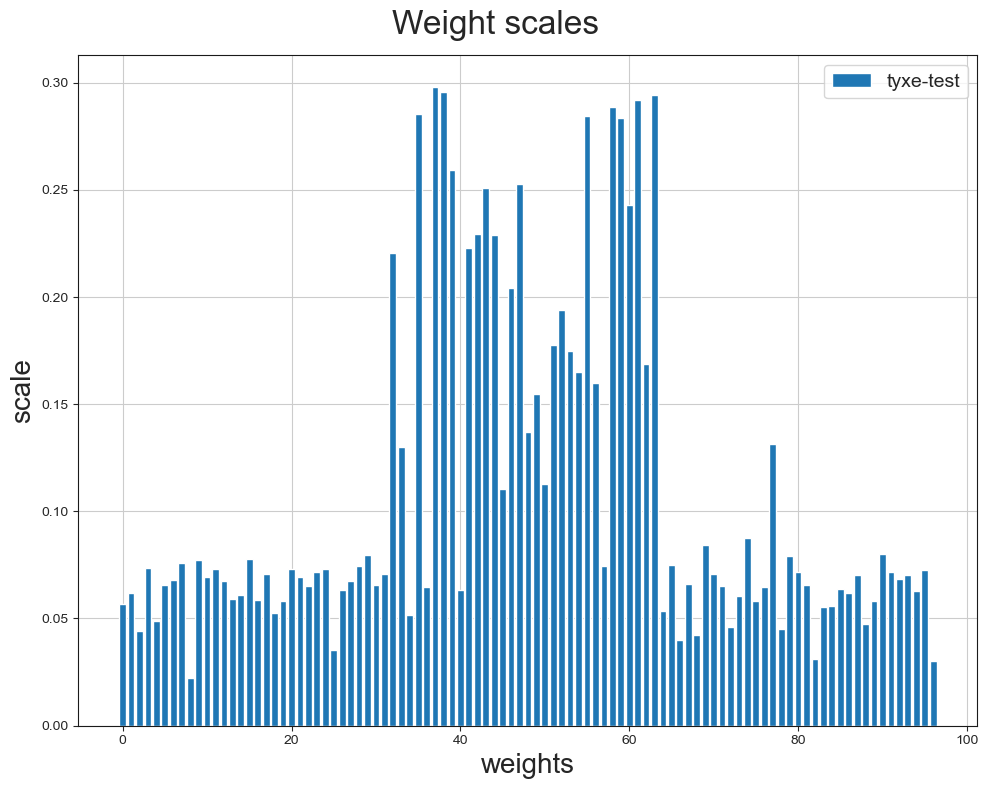

In [19]:
#ws hist
fig, ax = plt.subplots(figsize=(10, 8))
fig.suptitle("Weight scales", fontsize=24)

name = "tyxe-test"
ws = weight_scales[name]

ax.hist(ws, label=f"{name}")

ax.legend(fontsize=14)
ax.set_xlabel("weight_scale", fontsize=20)
ax.set_ylabel("density", fontsize=20)
#tight layout
plt.tight_layout()
plt.savefig(f"{BASE_DIR}/plots/weight_scales.svg", format="svg")
plt.show()


#ws bar
fig, ax = plt.subplots(figsize=(10, 8))
fig.suptitle("Weight scales", fontsize=24)

name = "tyxe-test"
ws = weight_scales[name]
names = [i for i in range(len(ws))]

ax.bar(names, ws, label=f"{name}")

ax.legend(fontsize=14)
ax.set_xlabel("weights", fontsize=20)
ax.set_ylabel("scale", fontsize=20)
#tight layout
plt.tight_layout()
plt.savefig(f"{BASE_DIR}/plots/weight_scales2.svg", format="svg")
plt.show()

In [20]:
##load train uncertainties

uncertainties = {}
for p in profiles:
    name = configs[p]["NAME"]
    uncertainties[name] = []
    for run in range(1, reruns+1):
        with open(f"{BASE_DIR}/results/{name}/uncertainties_{run}.json", "r") as f:
            uncertainties[name].append(json.load(f))


In [21]:
train_stds = uncertainties["tyxe-test"][0]["train"]["pred_dist"]["std"]

In [22]:
train_stds

[0.3150298595428467,
 0.33820340037345886,
 0.30390870571136475,
 0.30805084109306335,
 0.3086893558502197,
 0.3676203787326813,
 0.3758928179740906,
 0.3091237545013428,
 0.30552539229393005,
 0.3047654330730438,
 0.31569167971611023,
 0.31318584084510803,
 0.35708415508270264,
 0.32857173681259155,
 0.32538509368896484,
 0.31887906789779663,
 0.3101840019226074,
 0.316664457321167,
 0.39269229769706726,
 0.3084784150123596,
 0.32798364758491516,
 0.3164176344871521,
 0.34209582209587097,
 0.3553757071495056,
 0.3043643832206726,
 0.3040305972099304,
 0.3123980760574341,
 0.34320390224456787,
 0.3063703179359436,
 0.38733553886413574,
 0.3268674314022064,
 0.4087708592414856,
 0.36286747455596924,
 0.30419570207595825,
 0.3249971270561218,
 0.31064197421073914,
 0.3830311894416809,
 0.35395896434783936,
 0.37587371468544006,
 0.30541691184043884,
 0.3372044563293457,
 0.30435317754745483,
 0.38437625765800476,
 0.31804338097572327,
 0.37036043405532837,
 0.3526240289211273,
 0.3043171

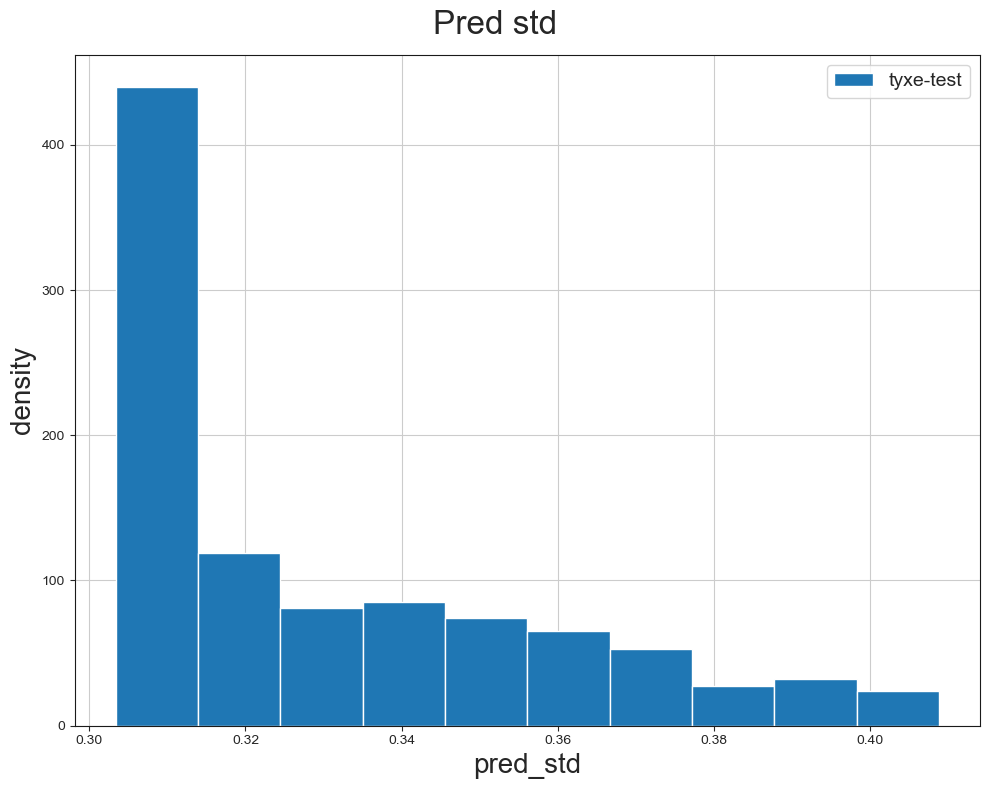

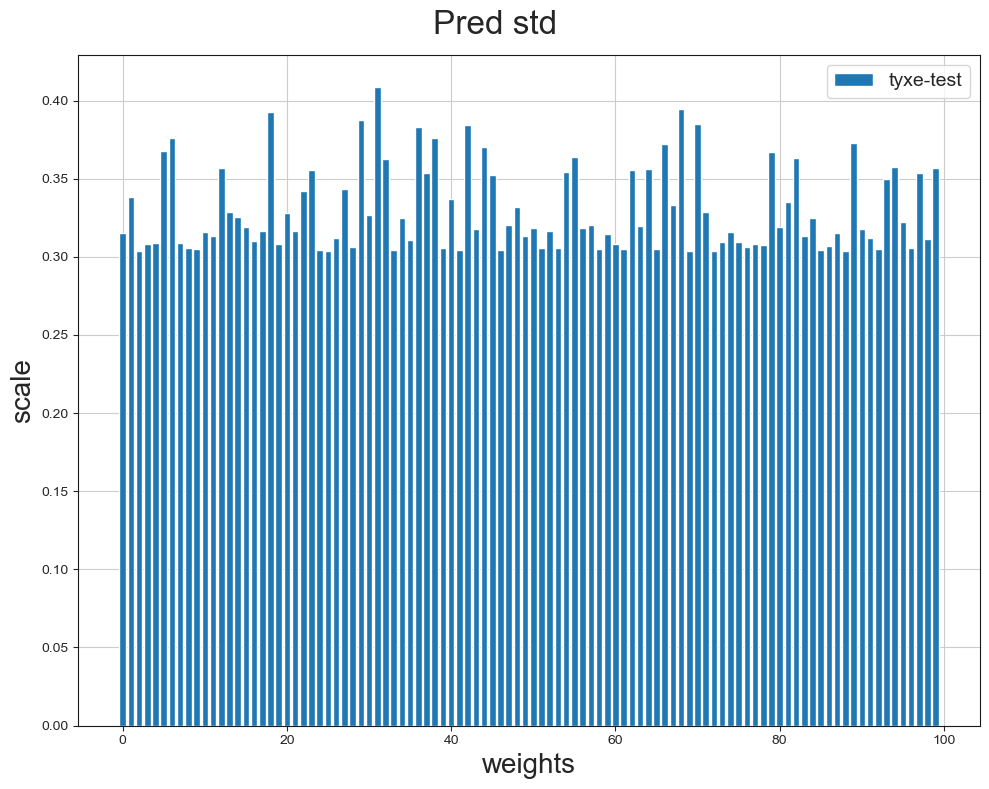

In [25]:
#ws hist
fig, ax = plt.subplots(figsize=(10, 8))
fig.suptitle("Pred std", fontsize=24)

name = "tyxe-test"
stds = train_stds

ax.hist(stds, label=f"{name}")

ax.legend(fontsize=14)
ax.set_xlabel("pred_std", fontsize=20)
ax.set_ylabel("density", fontsize=20)
#tight layout
plt.tight_layout()
plt.savefig(f"{BASE_DIR}/plots/pred_stds.svg", format="svg")
plt.show()


#ws bar
fig, ax = plt.subplots(figsize=(10, 8))
fig.suptitle("Pred std", fontsize=24)

name = "tyxe-test"
stds = train_stds[:100]
names = [i for i in range(len(stds))]

ax.bar(names, stds, label=f"{name}")

ax.legend(fontsize=14)
ax.set_xlabel("weights", fontsize=20)
ax.set_ylabel("scale", fontsize=20)
#tight layout
plt.tight_layout()
plt.savefig(f"{BASE_DIR}/plots/pred_stds2.svg", format="svg")
plt.show()